Load up experiment & annotations

In [1]:
import sys
sys.path.append('/tmp/pycharm_project_688')
sys.path.append('/tmp/pycharm_project_688/src')

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from tsfresh import select_features
from tsfresh.utilities.dataframe_functions import impute

%load_ext autoreload
%autoreload 2


from classification.classification import classify_all
from data_reading.phyphox import read_experiment
from features import extract_timeseries_features
from file_handling import get_sub_directories
from preprocessing import align_data, segment_windows, merge_left_and_right_chunk
from visualization import plot_duration_histogram

In [3]:
experiment_dir_path = "/tmp/pycharm_project_688/data/phyphox/full recordings/"
experiment_dirs = get_sub_directories(experiment_dir_path)
complete_experiments_indices = [1,2,3,5,7]
# Anne marvin julius fabi cilly
experiment_dirs = [experiment_dirs[i] for i in complete_experiments_indices]
print(experiment_dirs)
sample_rate = 50
chunks = {"right": [], "left": []}
null_chunks = {"right": [], "left": []}
y_columns = ["start", "end", "label", "hand"]
y = pd.DataFrame(columns=y_columns)
#del experiment_dirs[1]
for directory in experiment_dirs:
    offsets = {}
    with open(directory + "/offset.txt") as f:
        for line in f:
           (key, val) = line.split(": ")
           offsets[key.lower()] = val

    data_frames = read_experiment(directory, offsets=offsets)
    data_frames = {key : align_data(data_frame, listening_rate=1000/sample_rate, reference_sensor=None) for key, data_frame in data_frames.items()}

    y_user = pd.read_csv(directory + "/annotations.tsv", delimiter="\t", header=None)
    hands = pd.read_csv(directory + "/hands.tsv", delimiter="\t", header=None)
    y_user = y_user.iloc[:, [3,5,8]]
    hands = hands.iloc[:, [8]]
    y_user = pd.concat([y_user, hands], axis=1)
    y_user.columns = y_columns
    y = pd.concat([y, y_user], axis=0)

    # iterate over the annotations and split the timeseries in chunks
    for key, df in data_frames.items():
        if key in chunks:
            chunks[key] += [df.iloc[int(annotation["start"]*sample_rate):int(annotation["end"]*sample_rate)] for i, annotation in y_user.iterrows()]
            # null chunks are everything in between annotations
            null_chunks[key] += [df.iloc[int(annotation["end"]*sample_rate):int(y_user.iloc[i+1:i+2]["start"]*sample_rate)] for i, annotation in y_user.iterrows() if i < len(y_user)-1]

['/tmp/pycharm_project_688/data/phyphox/full recordings/Anne', '/tmp/pycharm_project_688/data/phyphox/full recordings/Fabi', '/tmp/pycharm_project_688/data/phyphox/full recordings/Marvin', '/tmp/pycharm_project_688/data/phyphox/full recordings/Cilly', '/tmp/pycharm_project_688/data/phyphox/full recordings/Julius']


/tmp/pycharm_project_688/src/preprocessing/_data_frame.py:31: FutureWarning: Passing datetime64-dtype data to TimedeltaIndex is deprecated, will raise a TypeError in a future version
  time_delta_index = pd.TimedeltaIndex(timestamp_to_date, unit=output_timestamp_unit)


In [4]:
experiment_dirs

['/tmp/pycharm_project_688/data/phyphox/full recordings/Anne',
 '/tmp/pycharm_project_688/data/phyphox/full recordings/Fabi',
 '/tmp/pycharm_project_688/data/phyphox/full recordings/Marvin',
 '/tmp/pycharm_project_688/data/phyphox/full recordings/Cilly',
 '/tmp/pycharm_project_688/data/phyphox/full recordings/Julius']

Preprocess data

No handles with labels found to put in legend.


Mean 6.89 +/- 8.77


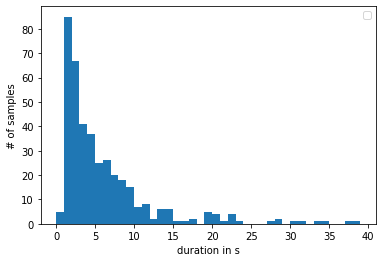

In [5]:
plot_duration_histogram(chunks["right"])

No handles with labels found to put in legend.


Mean 8.62 +/- 26.71


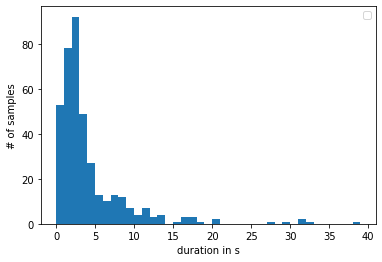

In [6]:
plot_duration_histogram(null_chunks["right"])

In [7]:
# append the activity label (as int) and the action id to the dataframe
# we need to do this to be able to extract time series features later

labels = y.loc[:, "label"].unique()
label_ids = { l: i for l,i in zip(labels, range(0,len(labels))) }

# list of tuples (left chunk, right chunk)
chunks_two_handed = []
# list of chunks
chunks_one_handed = []

y = y.replace(label_ids)


for i, cl in zip(range(len(y)), y.iterrows()):
    label_id = int(cl[1]["label"])
    action_id = i
    two_handed_chunk = []
    for hand, chunk_list in chunks.items():
        c = chunk_list[i]
        chunk_hand = cl[1]["hand"]
        two_handed_chunk.append(c)
        one_handed_chunk = c
        one_handed_chunk["action_id"] = action_id
        if chunk_hand == hand:
            #c["activity"] = label_id
            chunks_one_handed.append(one_handed_chunk)
    two_handed_chunk = merge_left_and_right_chunk(two_handed_chunk[0], two_handed_chunk[1], action_id)
    chunks_two_handed.append(two_handed_chunk)

labels = y.loc[:, "label"].squeeze()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Feature extraction for 2 handed activities

In [8]:
window_size = 100

In [9]:
# prepare null chunks
null_class_chunks = []

# TODO: assert that this list is disjoint to the list of action ids from activities
null_action_ids = range(len(chunks_two_handed),len(chunks_two_handed)+len(null_chunks["right"]))
for c_r, c_l, action_id in zip(null_chunks["right"], null_chunks["left"], null_action_ids):
    if len(c_l):
        c_both = merge_left_and_right_chunk(c_l, c_r, action_id)
        null_class_chunks.append(c_both)

In [10]:
chunks_two_handed[1]

,linear_acceleration x,linear_acceleration y,linear_acceleration z,gyroscope x,gyroscope y,gyroscope z,acceleration x,acceleration y,acceleration z,action_id,linear_acceleration x_right,linear_acceleration y_right,linear_acceleration z_right,gyroscope x_right,gyroscope y_right,gyroscope z_right,acceleration x_right,acceleration y_right,acceleration z_right
index,,,,,,,,,,,,,,,,,,,
00:00:43.593434,1.241795,1.292552,1.739741,0.145761,0.250118,0.165608,6.601590,-3.772225,6.449613,1,-0.290797,0.096008,-0.506259,0.361070,0.540261,0.412924,-10.505976,-4.033951,-2.839155
00:00:43.613434,1.370152,1.371444,0.987696,0.059828,-0.101145,0.290472,7.044789,-3.207028,6.249347,1,-0.407427,0.584174,-0.920251,0.315623,0.075510,0.432136,-10.175085,-3.770906,-2.838916
00:00:43.633434,0.163912,1.785413,-0.241045,-0.062185,-0.307072,0.305440,6.939132,-2.585456,6.650985,1,-0.808520,0.205763,-1.448561,0.235554,-0.021557,0.316371,-9.454178,-3.365174,-2.080154
00:00:43.653434,-0.630352,2.641270,-0.453729,-0.105295,-0.315797,0.279803,7.099795,-2.792531,6.343907,1,-0.583099,-0.372610,-0.905201,0.189308,0.028696,0.156142,-9.383839,-3.443178,-1.823782
00:00:43.673434,0.514827,3.466039,0.323057,-0.052081,-0.156316,0.261539,7.367973,-3.337009,5.886556,1,-0.127590,-0.659300,0.395816,0.159099,-0.064123,0.060200,-9.598887,-3.858637,-2.079621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00:00:45.993434,0.168967,0.008544,-1.175266,-0.142900,0.966739,-0.048474,4.082710,-3.721591,8.297028,1,-0.424516,-0.753092,0.807795,0.027909,0.075126,0.059066,-8.924892,-4.607743,-1.455240
00:00:46.013434,-0.467971,1.743179,-1.542913,-0.159949,0.949245,-0.049470,3.820958,-3.776317,8.174863,1,-0.570494,-0.435285,0.735600,-0.013138,0.220463,0.046101,-8.686695,-4.479869,-1.494355
00:00:46.033434,-0.538641,3.088994,-1.706700,-0.187710,0.863829,-0.027110,3.743985,-3.853337,8.169260,1,-0.710521,0.042907,0.281398,-0.011137,0.341306,0.050570,-8.985566,-4.569226,-1.403968


## Classification step 1: OCD activities vs null class samples

In [11]:
# new label id for ocd activities
labels_ocd_acts = pd.Series([labels.max()+2] * len(chunks_two_handed))
chunks_ocd_activities, labels_ocd_acts = segment_windows(chunks_two_handed, labels_ocd_acts.to_numpy(), window_size)

/tmp/pycharm_project_688/src/preprocessing/_segmentation.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_new["action_id"] = [(action_id, i)] * len(c_new)


In [12]:
chunks_ocd_activities[9]

,linear_acceleration x,linear_acceleration y,linear_acceleration z,gyroscope x,gyroscope y,gyroscope z,acceleration x,acceleration y,acceleration z,action_id,linear_acceleration x_right,linear_acceleration y_right,linear_acceleration z_right,gyroscope x_right,gyroscope y_right,gyroscope z_right,acceleration x_right,acceleration y_right,acceleration z_right
index,,,,,,,,,,,,,,,,,,,
00:01:20.793434,0.342304,0.049179,0.104684,0.045496,-0.033597,-0.779790,-0.177778,2.657655,9.143495,"(9, 0)",0.180139,0.023704,-0.120108,0.176846,-0.685247,-0.051998,-3.333902,9.125586,0.870966
00:01:20.813434,0.232606,0.078618,-0.143458,0.073374,-0.115926,-0.788350,-0.440253,2.803315,8.865083,"(9, 0)",0.172095,0.015175,-0.072720,0.178266,-0.718274,-0.049109,-3.298276,9.126298,0.837299
00:01:20.833434,0.252931,0.183173,-0.171002,0.081190,-0.291815,-0.794369,-0.453612,2.786744,8.705465,"(9, 0)",0.194112,0.070004,-0.009604,0.172269,-0.751426,-0.053886,-3.246883,9.206754,0.768568
00:01:20.853434,0.268682,0.201068,-0.029366,0.046971,-0.492572,-0.787509,-0.318405,2.837807,8.874006,"(9, 0)",0.135502,0.097545,-0.111288,0.161576,-0.778747,-0.058986,-3.194440,9.205785,0.696085
00:01:20.873434,0.218942,0.086090,0.130772,0.068884,-0.633992,-0.775096,-0.257870,2.838789,8.663959,"(9, 0)",0.116467,0.109597,-0.130967,0.150030,-0.777047,-0.058218,-3.131817,9.212507,0.707030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00:01:22.693434,-0.079502,-0.372221,-1.010718,0.007916,0.012681,-0.086510,1.788811,9.073842,2.559214,"(9, 0)",-0.156557,-0.272676,-0.238838,-0.097959,0.315000,-0.093031,-3.438742,9.119474,0.580147
00:01:22.713434,1.050920,-0.787270,-1.379982,0.037907,0.095530,-0.101725,2.029277,9.138050,2.485785,"(9, 0)",-0.150426,-0.186959,-0.218560,-0.070552,0.343130,-0.088499,-3.481012,9.148380,0.668888
00:01:22.733434,1.472339,-0.654065,-1.471521,0.054826,0.103774,-0.048449,2.086192,9.328178,2.482735,"(9, 0)",-0.176132,-0.108510,-0.172597,-0.060614,0.360102,-0.087408,-3.484338,9.120376,0.589723


In [13]:
null_labels = pd.Series([labels.max()+1] * len(null_class_chunks))
null_class_chunks, null_labels = segment_windows(null_class_chunks, null_labels.to_numpy(), window_size)

In [14]:
null_class_chunks[9]

# TODO: assert that len(null_class_chunks.columns) == len(chunks_ocd_activities.columns)


,linear_acceleration x,linear_acceleration y,linear_acceleration z,gyroscope x,gyroscope y,gyroscope z,acceleration x,acceleration y,acceleration z,linear_acceleration x_right,linear_acceleration y_right,linear_acceleration z_right,gyroscope x_right,gyroscope y_right,gyroscope z_right,acceleration x_right,acceleration y_right,acceleration z_right,action_id
index,,,,,,,,,,,,,,,,,,,
00:01:13.109171,-0.193130,-0.059388,-0.166903,0.299580,-0.877738,-0.077795,-2.769057,8.847681,0.377935,0.531566,0.259566,-0.048185,1.685170,-0.041544,-1.252212,5.989186,8.523747,5.589470,"(411, 0)"
00:01:13.129171,-0.277783,-0.070524,-0.331906,0.317804,-0.770008,-0.073556,-2.834643,8.797194,0.323329,0.955572,0.193298,-0.122040,1.625201,-0.226193,-1.201879,5.472811,9.472362,5.495513,"(411, 0)"
00:01:13.149171,-0.246723,-0.166098,-0.207491,0.345043,-0.721227,-0.050700,-2.870088,8.852076,0.272546,0.890201,-0.112210,0.050375,1.625046,-0.273541,-1.179608,5.317876,10.164014,5.116118,"(411, 0)"
00:01:13.169171,-0.097703,-0.138099,-0.001944,0.345891,-0.603907,-0.034250,-2.807912,9.001083,0.208886,0.568393,-0.145690,-0.347290,1.605201,-0.207791,-1.081671,5.535360,10.204707,5.160065,"(411, 0)"
00:01:13.189171,-0.009165,-0.032783,-0.037764,0.296121,-0.466894,-0.039752,-2.693385,9.040164,0.112119,0.160105,0.068186,-0.329497,1.502558,-0.124896,-0.921459,5.472547,10.019044,5.413677,"(411, 0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00:01:15.009171,0.166857,0.165389,-0.149861,-0.130044,0.666179,0.107289,-3.657584,9.248623,0.740396,1.641561,0.761698,2.768798,-0.013670,0.942839,0.498537,1.962389,3.629725,8.431989,"(411, 0)"
00:01:15.029171,0.205678,0.182535,-0.199457,-0.137872,0.694124,0.087688,-3.759238,9.142792,0.682803,1.908288,1.040324,2.198518,-0.008121,0.888284,0.470130,1.585806,3.773667,8.470440,"(411, 0)"
00:01:15.049171,0.191421,0.147451,-0.332394,-0.129711,0.675423,0.078014,-3.818802,9.068053,0.556934,2.384875,1.027485,1.569531,-0.009841,0.790892,0.445208,1.591859,3.730380,8.569851,"(411, 0)"


### Feature extraction for OCD activities vs non-OCD activities

In [15]:
null_classification_concat = pd.concat(chunks_ocd_activities + null_class_chunks).reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [16]:
#null_classification_concat = null_classification_concat.drop(columns=["acceleration x", "acceleration x_right", "acceleration y", "acceleration y_right", "acceleration z", "acceleration z_right"])
#display(null_classification_concat)
null_classification_concat["action_id"].nunique()

2744

In [17]:
features_two_handed_null_test = extract_timeseries_features(null_classification_concat)

Feature Extraction: 100%|██████████| 30/30 [09:13<00:00, 18.46s/it]


### Feature selection for OCD activities vs non-OCD activities

In [18]:
labels_null_classification = pd.concat([labels_ocd_acts, null_labels])

In [19]:
labels_null_classification

(0, 0)      21
(1, 0)      21
(2, 0)      21
(3, 0)      21
(4, 0)      21
            ..
(800, 2)    20
(800, 3)    20
(800, 4)    20
(802, 0)    20
(804, 0)    20
Length: 2744, dtype: int64

In [20]:
impute(features_two_handed_null_test)
X_two_handed_selected_null_test = select_features(features_two_handed_null_test, labels_null_classification)
X_two_handed_selected_null_test

/usr/local/lib/python3.6/dist-packages/tsfresh/utilities/dataframe_functions.py:173: RuntimeWarning: The columns ['acceleration x__fft_coefficient__attr_"abs"__coeff_51'
 'acceleration x__fft_coefficient__attr_"abs"__coeff_52'
 'acceleration x__fft_coefficient__attr_"abs"__coeff_53' ...
 'linear_acceleration z_right__fft_coefficient__attr_"real"__coeff_97'
 'linear_acceleration z_right__fft_coefficient__attr_"real"__coeff_98'
 'linear_acceleration z_right__fft_coefficient__attr_"real"__coeff_99'] did not have any finite values. Filling with zeros.
  df.iloc[:, np.where(is_col_non_finite)[0]].columns.values), RuntimeWarning)


variable,"acceleration x__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)","acceleration x_right__cwt_coefficients__coeff_4__w_20__widths_(2, 5, 10, 20)","acceleration x_right__cwt_coefficients__coeff_4__w_10__widths_(2, 5, 10, 20)",acceleration x__sum_values,"acceleration x_right__cwt_coefficients__coeff_3__w_5__widths_(2, 5, 10, 20)","acceleration x_right__cwt_coefficients__coeff_3__w_2__widths_(2, 5, 10, 20)","acceleration x_right__cwt_coefficients__coeff_3__w_20__widths_(2, 5, 10, 20)",acceleration x__variation_coefficient,"acceleration x_right__cwt_coefficients__coeff_3__w_10__widths_(2, 5, 10, 20)","acceleration x_right__cwt_coefficients__coeff_4__w_2__widths_(2, 5, 10, 20)",...,gyroscope x__approximate_entropy__m_2__r_0.5,"acceleration y_right__fft_coefficient__attr_""abs""__coeff_40","acceleration x_right__fft_coefficient__attr_""abs""__coeff_50","linear_acceleration x_right__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""min""","gyroscope y__change_quantiles__f_agg_""mean""__isabs_False__qh_0.4__ql_0.2",acceleration x__sample_entropy,"acceleration z_right__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.8","gyroscope x__change_quantiles__f_agg_""mean""__isabs_False__qh_0.8__ql_0.2","acceleration y_right__fft_coefficient__attr_""abs""__coeff_44","linear_acceleration y_right__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""var"""
id,,,,,,,,,,,,,,,,,,,,,
"(0, 0)",2.513435,-3.393301,-1.894111,157.410420,-0.381004,-2.962768,-2.984018,0.595646,-0.933046,-0.431174,...,0.228823,0.779026,0.551710,-0.009059,0.021501,0.504556,1.916374,0.000933,0.750953,0.526202
"(1, 0)",7.238397,-11.132701,-9.371342,617.074078,-10.047734,-6.001737,-9.406748,0.135104,-7.397250,-3.349723,...,0.317450,0.531680,0.678827,0.464564,-0.007396,0.665201,0.052248,-0.000340,0.356186,0.115896
"(2, 0)",4.488306,-10.715016,-9.118136,355.419354,-8.810281,-5.540411,-9.045866,1.002168,-7.090866,-2.802638,...,0.236106,8.143945,2.320018,0.477426,0.005362,0.168661,0.112877,0.000758,7.771399,-0.026231
"(3, 0)",-5.550540,-1.439960,-2.625828,287.325447,-3.412109,-1.942002,-0.917312,0.762728,-2.220694,-0.719706,...,0.105114,0.190483,0.225431,-0.747984,-0.027627,0.478848,0.183653,-0.014994,0.299980,0.499102
"(4, 0)",-15.651638,-4.297464,-4.100441,205.911621,-3.604369,-1.947408,-3.741680,1.499567,-3.324784,-1.432570,...,0.215740,0.113144,0.175559,0.345547,0.097280,0.436305,0.008852,-0.003969,0.127474,-0.164932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(800, 2)",-7.425662,9.516208,8.125651,-716.755498,7.835590,4.861285,8.029154,-0.008897,6.309168,2.644076,...,0.481629,0.070971,0.004743,0.068141,0.000647,0.806906,0.000074,0.000124,0.064611,0.456165
"(800, 3)",-7.163835,9.526682,8.138676,-756.686277,7.819031,4.897865,8.031464,-0.079534,6.310693,2.654521,...,0.060657,0.034517,0.007783,-0.186599,0.000587,0.134121,0.000089,0.005697,0.028711,-0.091609
"(800, 4)",-13.234245,9.590222,8.214800,-689.348096,7.892697,4.931031,8.098404,-0.247851,6.389086,2.703546,...,0.159050,0.061743,0.116882,0.452617,-0.006613,0.664976,0.000010,-0.015250,0.063119,-0.308311


In [21]:
# TODO: feature visualization: scatter plot - explain what happens

In [22]:
scaler = StandardScaler()
X_null_classification = scaler.fit_transform(X_two_handed_selected_null_test)

### Train models and score results

In [23]:
print("Two handed classification")
classify_all(X_null_classification, labels_null_classification)

Two handed classification
Logistic Regression: 0.99 +/- 0.01
LDA: 0.91 +/- 0.03
LinearSVC: 0.99 +/- 0.01
CART: 0.98 +/- 0.01
Random Forest: 0.99 +/- 0.01
XGBoost binary: 0.99 +/- 0.01
XGBoost mult: nan +/- nan
NB: 0.90 +/- 0.03


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/Fabian.Stolp/.local/lib/python3.6/site-packages/xgboost/sklearn.py", line 824, in fit
    callbacks=callbacks)
  File "/home/Fabian.Stolp/.local/lib/python3.6/site-packages/xgboost/training.py", line 212, in train
    xgb_model=xgb_model, callbacks=callbacks)
  File "/home/Fabian.Stolp/.local/lib/python3.6/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/home/Fabian.Stolp/.local/lib/python3.6/site-packages/xgboost/core.py", line 1369, in update
    dtrain.handle))
  File "/home/Fabian.Stolp/.local/lib/python3.6/

In [24]:
# TODO: plot feature importance (which feature has the most impact on the results)

#sns.pairplot(X_null_classification[:, :10])


In [25]:
chunks_two_handed_segmented, labels = segment_windows(chunks_two_handed, labels.to_numpy(), window_size)


/tmp/pycharm_project_688/src/preprocessing/_segmentation.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_new["action_id"] = [(action_id, i)] * len(c_new)


### Feature extraction for 2 handed classifier of activities against each other

In [26]:
# here it was given "chunks_two_handed" ==>> error? TODO
df_against = pd.concat(chunks_two_handed_segmented).drop(columns=["acceleration x", "acceleration x_right", "acceleration y", "acceleration y_right", "acceleration z", "acceleration z_right"]).reset_index(drop=True)
df_against

,linear_acceleration x,linear_acceleration y,linear_acceleration z,gyroscope x,gyroscope y,gyroscope z,action_id,linear_acceleration x_right,linear_acceleration y_right,linear_acceleration z_right,gyroscope x_right,gyroscope y_right,gyroscope z_right
0,0.017523,0.225704,0.229357,0.092818,-0.104318,-0.050199,"(0, 0)",-1.110213,-0.098378,-0.225679,0.970563,-1.055736,0.153274
1,-0.117950,-0.005236,-0.230780,0.042478,0.050260,-0.082764,"(0, 0)",-1.064734,-0.105981,-0.382423,0.112896,-1.425347,0.167552
2,0.242792,-0.089553,-0.645910,-0.005306,0.159707,-0.083322,"(0, 0)",-0.946615,-0.247106,-0.361925,0.011911,-2.058642,-0.051693
3,1.035516,-0.030482,-1.002862,0.019021,0.112754,-0.059660,"(0, 0)",-0.603265,-0.291673,0.235737,0.508975,-1.698441,-0.298838
4,1.413947,0.084070,-1.207110,0.025346,-0.021961,-0.035204,"(0, 0)",-0.281613,-0.297726,0.699631,0.551109,-1.302738,-0.362414
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120195,-1.778945,2.258008,-7.076770,0.243362,1.585938,-1.111258,"(404, 1)",1.164013,1.990010,-1.165943,0.695765,0.316338,-1.485244
120196,0.169995,1.546356,-12.452490,0.199549,1.496782,-1.171139,"(404, 1)",1.222979,1.614055,-1.094402,0.718220,0.726940,-1.357496
120197,0.619204,4.840165,-4.775209,0.160712,1.409055,-1.191688,"(404, 1)",1.265777,0.950970,-1.075557,0.678670,0.649551,-1.191751
120198,2.006420,3.340541,-3.356300,0.207205,1.405969,-1.054521,"(404, 1)",1.232097,0.276336,-1.104165,0.633226,0.830995,-0.982520


In [27]:
features_two_handed = extract_timeseries_features(df_against)

Feature Extraction: 100%|██████████| 30/30 [02:41<00:00,  5.38s/it]


In [28]:
features_two_handed.replace([np.inf, -np.inf], np.nan, inplace=True)
features_two_handed.dropna(inplace=True, axis=1)
features_two_handed

variable,gyroscope x__abs_energy,gyroscope x__absolute_sum_of_changes,"gyroscope x__agg_autocorrelation__f_agg_""mean""__maxlag_40","gyroscope x__agg_autocorrelation__f_agg_""median""__maxlag_40","gyroscope x__agg_autocorrelation__f_agg_""var""__maxlag_40","gyroscope x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""","gyroscope x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""mean""","gyroscope x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""min""","gyroscope x__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""","gyroscope x__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""max""",...,linear_acceleration z_right__symmetry_looking__r_0.9500000000000001,linear_acceleration z_right__time_reversal_asymmetry_statistic__lag_1,linear_acceleration z_right__time_reversal_asymmetry_statistic__lag_2,linear_acceleration z_right__time_reversal_asymmetry_statistic__lag_3,linear_acceleration z_right__value_count__value_-1,linear_acceleration z_right__value_count__value_0,linear_acceleration z_right__value_count__value_1,linear_acceleration z_right__variance,linear_acceleration z_right__variance_larger_than_standard_deviation,linear_acceleration z_right__variation_coefficient
id,,,,,,,,,,,,,,,,,,,,,
"(0, 0)",10.654329,4.851955,0.001472,0.006931,0.218631,0.168997,0.201535,0.168843,-0.014239,0.394993,...,1.0,-0.060446,-0.129106,-0.262389,0.0,0.0,0.0,0.767381,0.0,6.176037
"(1, 0)",4.578473,4.135953,-0.040499,-0.157755,0.113890,0.011341,-0.063131,-0.134087,0.001682,0.145761,...,1.0,-0.008534,-0.053683,-0.062329,0.0,0.0,0.0,1.810286,1.0,10.247079
"(2, 0)",55.792643,8.568783,0.020291,-0.062535,0.177288,-0.175942,-0.140896,-0.131176,-0.009059,0.122677,...,1.0,0.002556,0.002240,0.000909,0.0,0.0,0.0,0.053048,0.0,-3.662430
"(3, 0)",127.479117,9.186056,0.243363,0.098113,0.142289,1.762715,1.432096,1.052949,0.075517,2.411285,...,1.0,-0.002543,-0.003491,-0.003436,0.0,0.0,0.0,0.094790,0.0,2.978299
"(4, 0)",67.322836,8.604984,0.149320,-0.064339,0.135896,1.074686,0.849489,0.665714,0.031455,1.724301,...,1.0,-0.000862,0.000422,0.001653,0.0,0.0,0.0,0.045502,0.0,-1.716229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(402, 1)",206.674275,13.005460,-0.174735,-0.432743,0.436856,0.865691,0.360905,-0.275730,0.193809,1.723460,...,1.0,-10.071393,-13.374439,-4.529924,0.0,0.0,0.0,33.122062,1.0,-4.086866
"(403, 0)",148.512433,9.822943,-0.028337,-0.245757,0.204488,1.248430,0.699694,0.174055,0.156262,2.049084,...,1.0,-0.009418,-0.047581,-0.120423,0.0,0.0,0.0,0.798049,0.0,-27.069531
"(403, 1)",19.840943,4.540336,-0.033821,-0.136255,0.191903,-0.010585,-0.399253,-0.693353,0.058590,0.651115,...,1.0,0.015233,0.030441,0.039400,0.0,0.0,0.0,0.761707,0.0,-4.145182


### Feature selection for 2 handed classifier of activities against each other

In [29]:
# Off-the-shelve feature selection from tsfresh

impute(features_two_handed)
X_two_handed_selected = select_features(features_two_handed, pd.Series(labels))
X_two_handed_selected

variable,"linear_acceleration y__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""mean""","linear_acceleration y__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""mean""","linear_acceleration y__linear_trend__attr_""pvalue""","linear_acceleration y__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""max""","linear_acceleration y__linear_trend__attr_""rvalue""",linear_acceleration z_right__longest_strike_below_mean,"linear_acceleration z__agg_linear_trend__attr_""rvalue""__chunk_len_5__f_agg_""min""",linear_acceleration y__autocorrelation__lag_9,linear_acceleration z_right__autocorrelation__lag_8,"linear_acceleration z_right__augmented_dickey_fuller__attr_""pvalue""__autolag_""AIC""",...,linear_acceleration x__large_standard_deviation__r_0.30000000000000004,gyroscope z_right__large_standard_deviation__r_0.30000000000000004,gyroscope z_right__large_standard_deviation__r_0.15000000000000002,gyroscope x__large_standard_deviation__r_0.35000000000000003,gyroscope z__symmetry_looking__r_0.15000000000000002,gyroscope z__ratio_value_number_to_time_series_length,gyroscope z__percentage_of_reoccurring_datapoints_to_all_datapoints,gyroscope z__large_standard_deviation__r_0.35000000000000003,gyroscope z__has_duplicate,gyroscope z__percentage_of_reoccurring_values_to_all_values
id,,,,,,,,,,,,,,,,,,,,,
"(0, 0)",-0.533317,-0.710777,3.979711e-06,-0.580158,-0.442739,19.0,0.588703,-0.003877,0.155160,0.255620,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
"(1, 0)",-0.486514,-0.601483,4.119133e-06,-0.481759,-0.442123,33.0,0.368767,0.237286,0.328329,0.017095,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
"(2, 0)",-0.549547,-0.619478,9.481066e-04,-0.412415,-0.325587,15.0,0.428818,0.104715,0.085464,0.491748,...,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
"(3, 0)",-0.511193,-0.567617,7.336156e-06,-0.527656,-0.431630,23.0,0.734137,0.283227,0.171319,0.529715,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
"(4, 0)",-0.916602,-0.961607,2.079960e-09,-0.678443,-0.554944,16.0,0.680294,0.238938,0.110875,0.104415,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(402, 1)",-0.315972,-0.476989,4.530085e-03,-0.396389,-0.281639,15.0,0.225129,-0.328991,-0.368005,0.000002,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
"(403, 0)",-0.022066,-0.081122,9.411396e-01,0.233411,-0.007478,30.0,-0.339971,-0.475008,0.246173,0.027354,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
"(403, 1)",-0.218975,-0.407835,8.876313e-02,-0.222239,-0.171090,23.0,0.295492,-0.531321,0.098149,0.027254,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


In [30]:
labels

(0, 0)       0
(1, 0)       1
(2, 0)       0
(3, 0)       1
(4, 0)       0
            ..
(402, 1)    13
(403, 0)    13
(403, 1)    13
(404, 0)    13
(404, 1)    13
Length: 1202, dtype: int64

In [31]:
scaler = StandardScaler()
X = scaler.fit_transform(X_two_handed_selected)

In [32]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_two_handed_selected = sel.fit_transform(X)

In [33]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X_two_handed_selected = SelectKBest(f_classif, k=2000).fit_transform(X, labels)
X_two_handed_selected

array([[-2.12312327, -2.34427742, -1.10203543, ...,  0.56077526,
        -0.09610378, -0.13007872],
       [-1.9290816 , -1.97154946, -1.10203498, ..., -0.57911519,
        -0.09610378, -0.13007872],
       [-2.19040944, -2.03291672, -1.09903757, ..., -0.82157271,
        -0.09610378, -0.13007872],
       ...,
       [-0.81988118, -1.31114612, -0.8202015 , ...,  0.31973547,
        -0.09610378, -0.13007872],
       [ 0.59953194,  0.67730942, -0.17600411, ...,  1.42429882,
        -0.09610378, -0.13007872],
       [ 0.90837716,  0.87687979, -0.88554987, ...,  1.28701959,
        -0.09610378, -0.13007872]])

Train models and score results

Two handed classification
Logistic Regression: 0.66 +/- 0.08
LDA: 0.59 +/- 0.04
LinearSVC: 0.64 +/- 0.07
CART: 0.47 +/- 0.03
Random Forest: 0.66 +/- 0.07
XGBoost binary: 0.69 +/- 0.07
XGBoost mult: 0.69 +/- 0.07
NB: 0.49 +/- 0.07


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in 

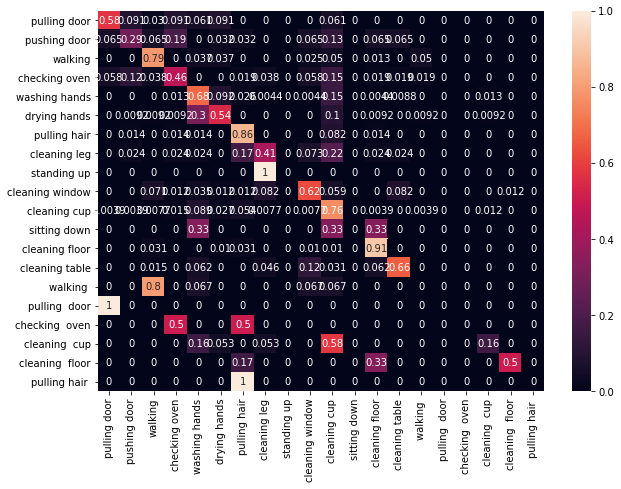

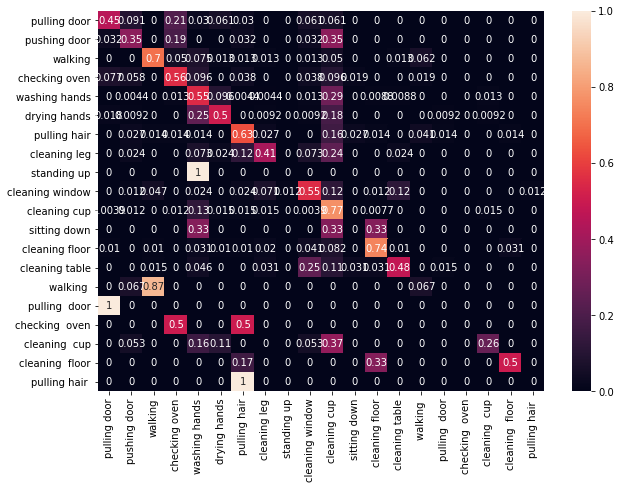

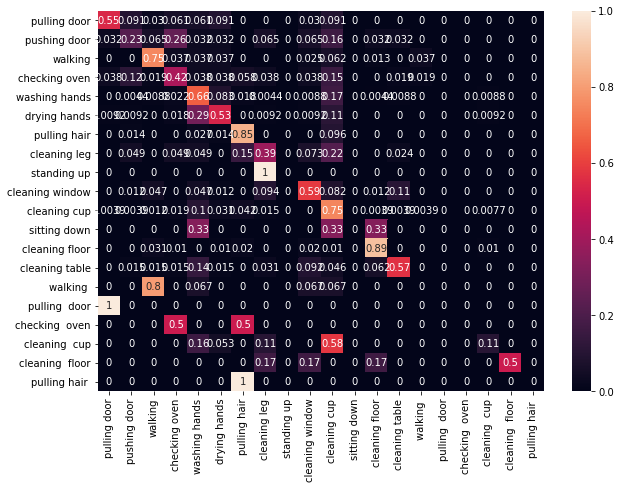

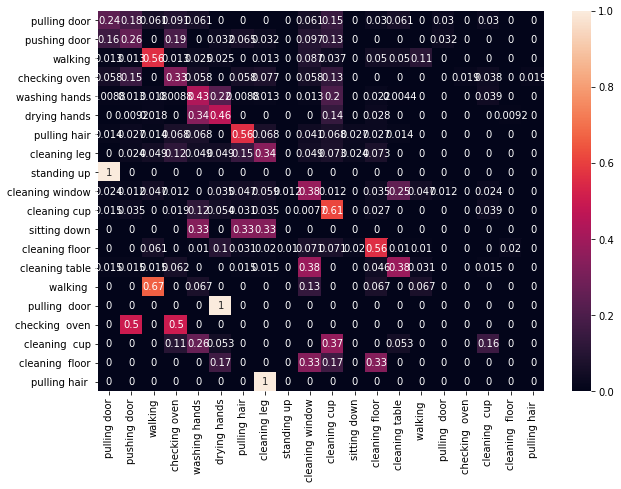

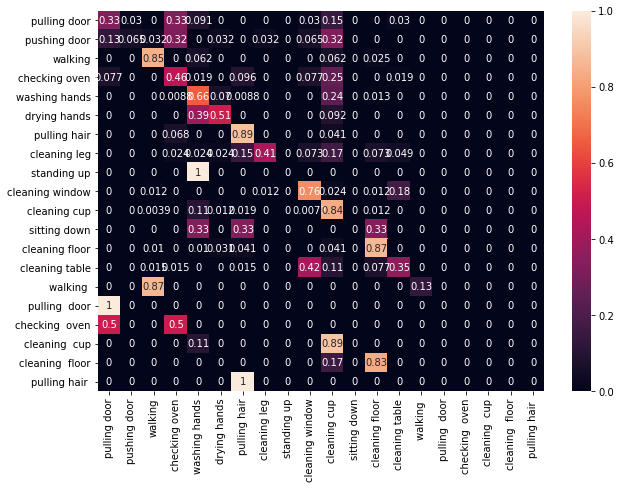

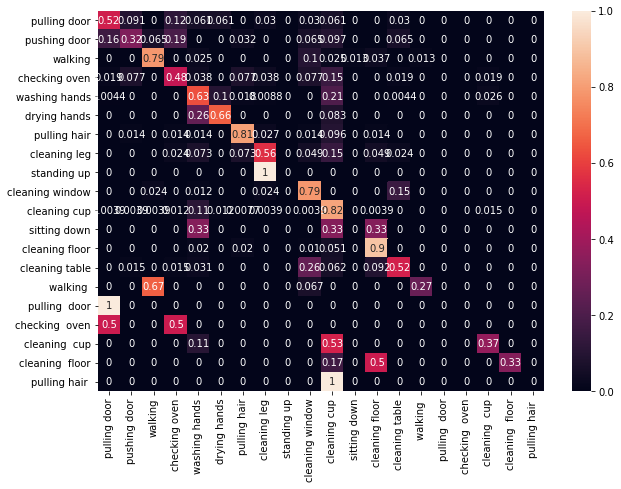

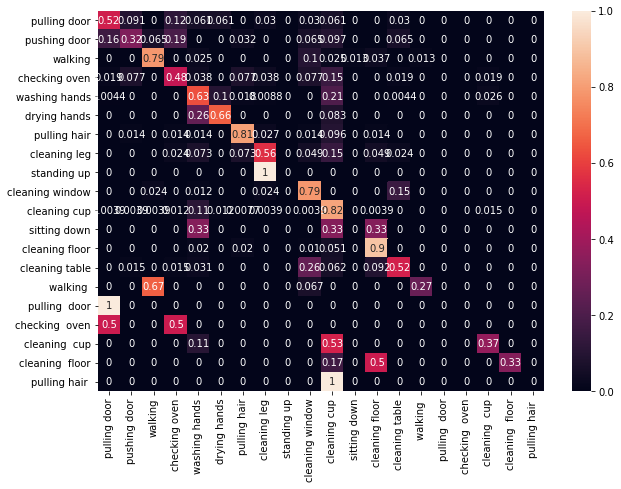

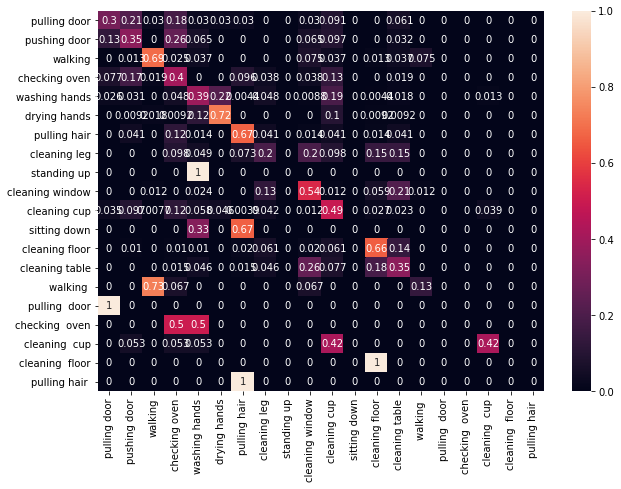

In [34]:
# TODO too many labels
print("Two handed classification")
classify_all(X, labels, label_ids)

Two handed classification
Logistic Regression: 0.66 +/- 0.08
LDA: 0.59 +/- 0.04
LinearSVC: 0.64 +/- 0.07
CART: 0.46 +/- 0.04
Random Forest: 0.67 +/- 0.06
XGBoost binary: 0.69 +/- 0.07
XGBoost mult: 0.69 +/- 0.07
NB: 0.49 +/- 0.07


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in 

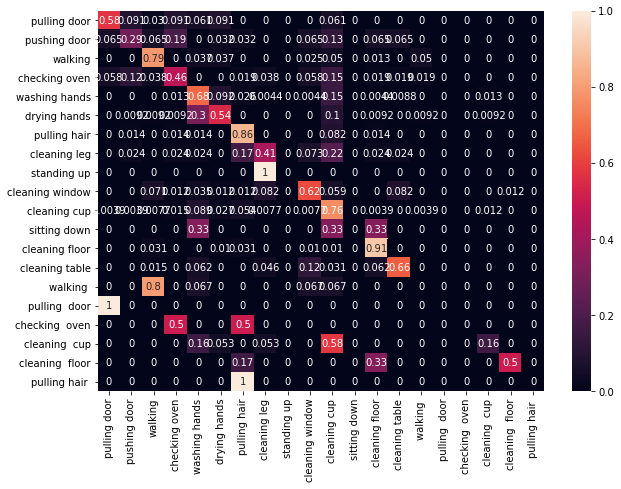

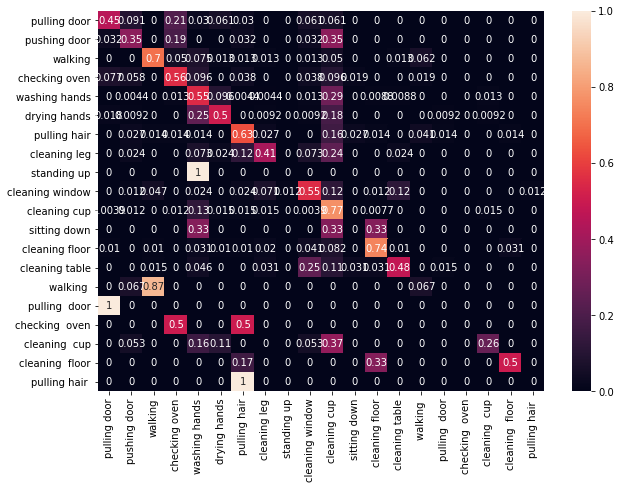

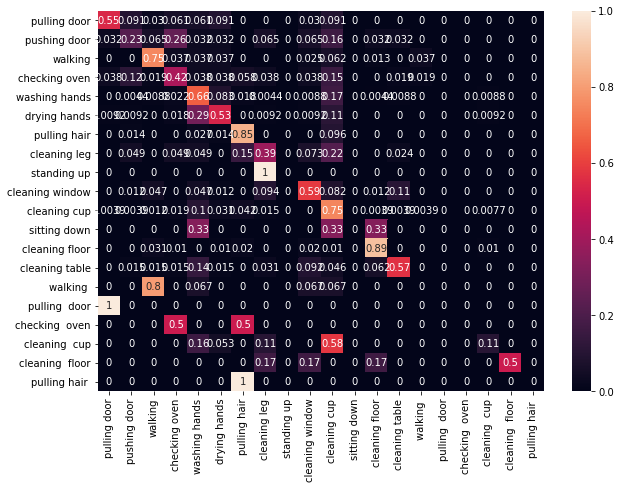

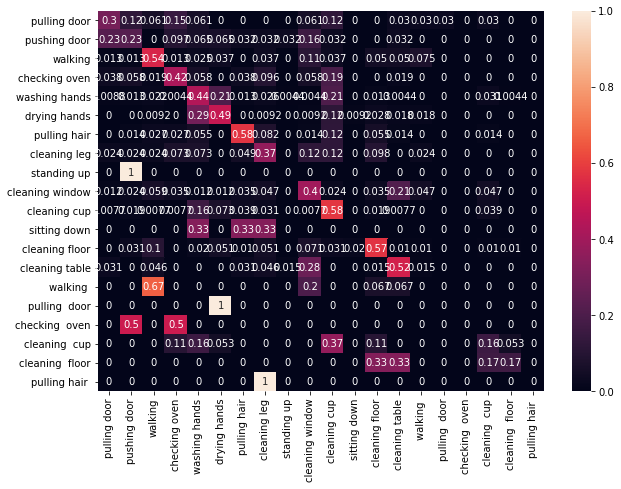

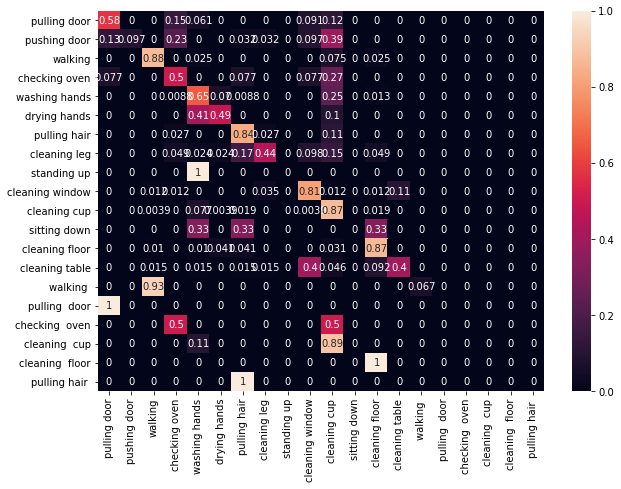

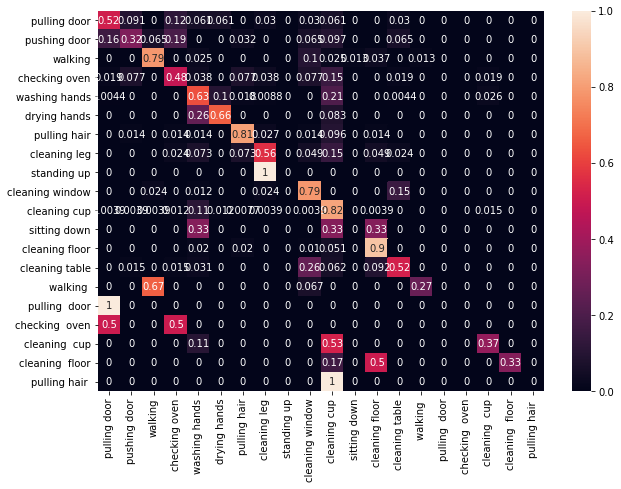

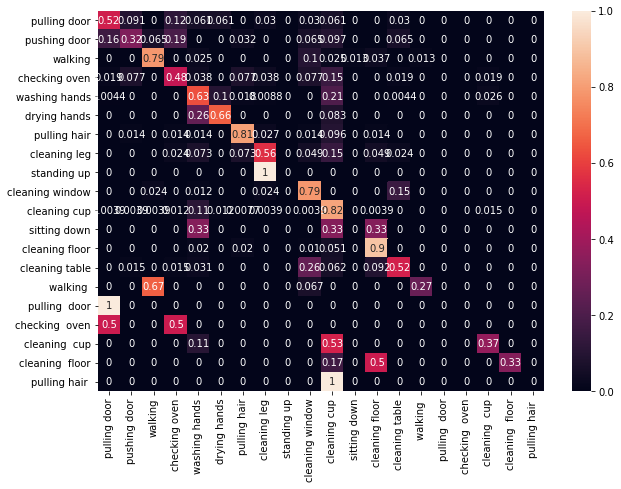

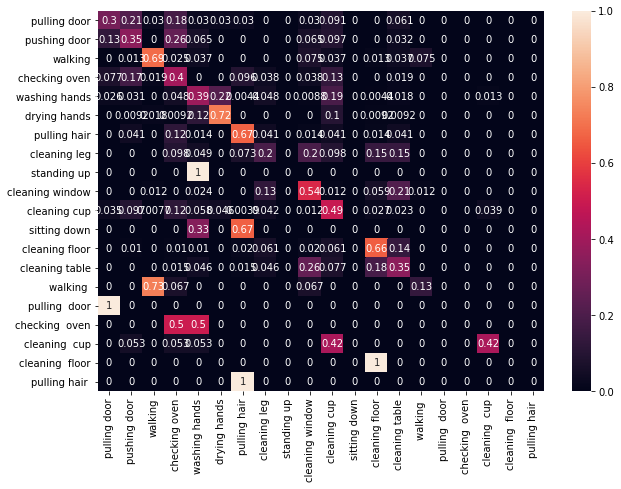

In [35]:
print("Two handed classification")
classify_all(X, labels, label_ids)

In [36]:
labels

(0, 0)       0
(1, 0)       1
(2, 0)       0
(3, 0)       1
(4, 0)       0
            ..
(402, 1)    13
(403, 0)    13
(403, 1)    13
(404, 0)    13
(404, 1)    13
Length: 1202, dtype: int64

In [37]:
scaler = StandardScaler()
X = scaler.fit_transform(X_two_handed_selected)

In [38]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
X_two_handed_selected = sel.fit_transform(X)

In [39]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

X_two_handed_selected = SelectKBest(f_classif, k=2000).fit_transform(X, labels)
X_two_handed_selected

array([[-2.12312327, -2.34427742, -1.10203543, ...,  0.56077526,
        -0.09610378, -0.13007872],
       [-1.9290816 , -1.97154946, -1.10203498, ..., -0.57911519,
        -0.09610378, -0.13007872],
       [-2.19040944, -2.03291672, -1.09903757, ..., -0.82157271,
        -0.09610378, -0.13007872],
       ...,
       [-0.81988118, -1.31114612, -0.8202015 , ...,  0.31973547,
        -0.09610378, -0.13007872],
       [ 0.59953194,  0.67730942, -0.17600411, ...,  1.42429882,
        -0.09610378, -0.13007872],
       [ 0.90837716,  0.87687979, -0.88554987, ...,  1.28701959,
        -0.09610378, -0.13007872]])

Train models and score results

Two handed classification
Logistic Regression: 0.65 +/- 0.07
LDA: 0.56 +/- 0.05
LinearSVC: 0.62 +/- 0.08
CART: 0.49 +/- 0.06
Random Forest: 0.66 +/- 0.07
XGBoost binary: 0.68 +/- 0.07
XGBoost mult: 0.68 +/- 0.07
NB: 0.50 +/- 0.08


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=8.
  % (min_groups, self.n_splits)), UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in 

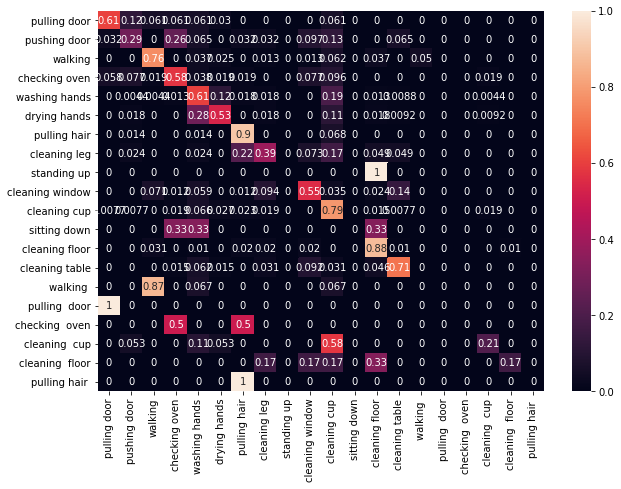

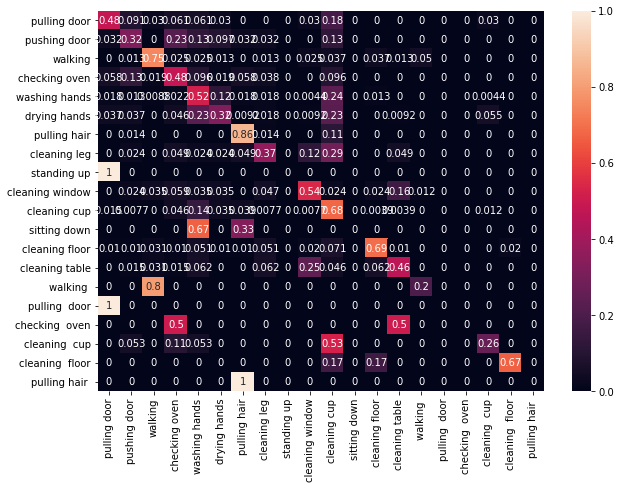

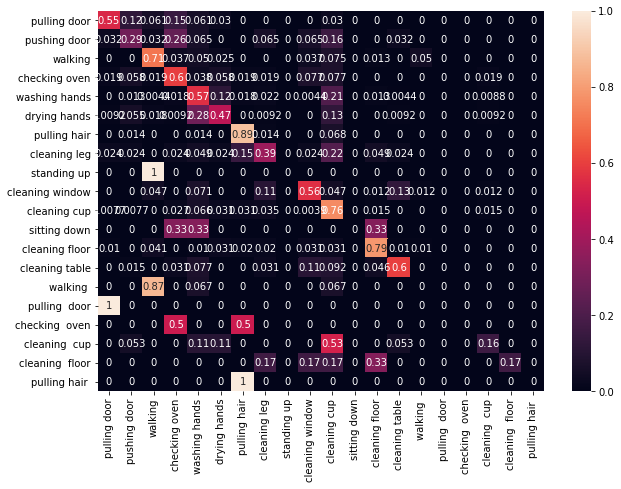

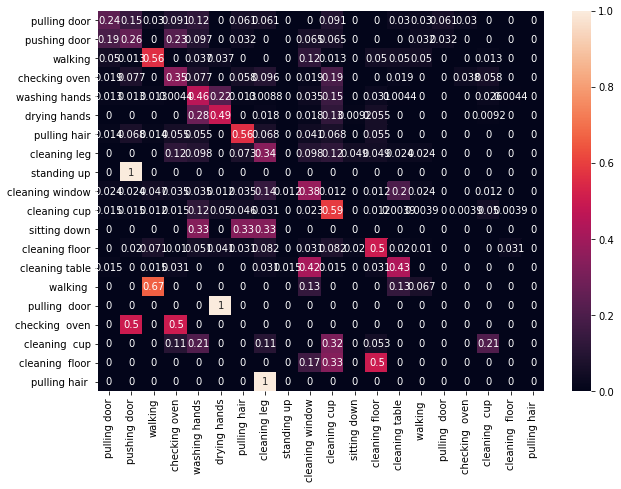

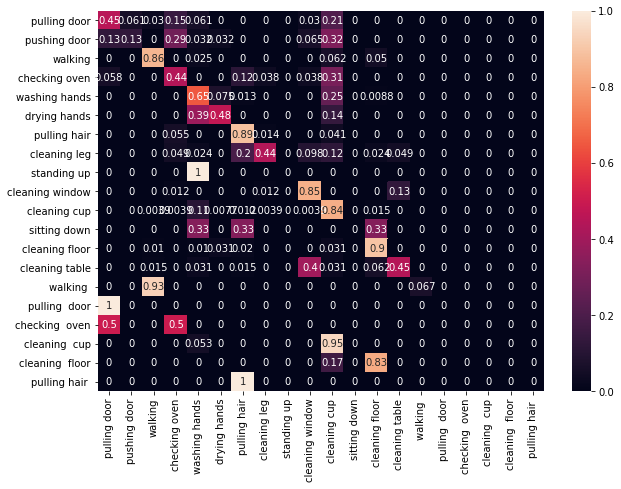

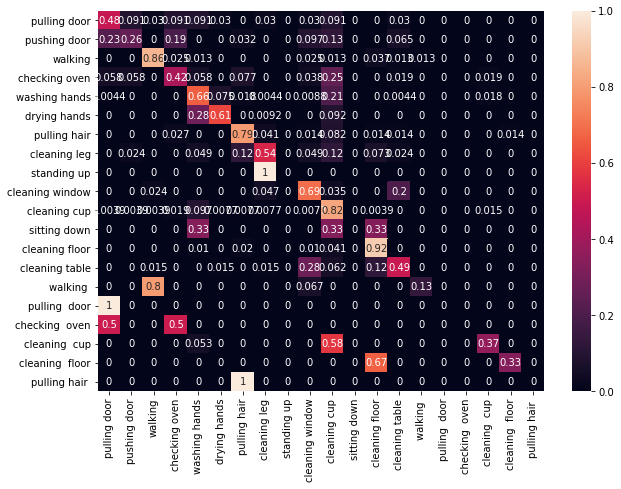

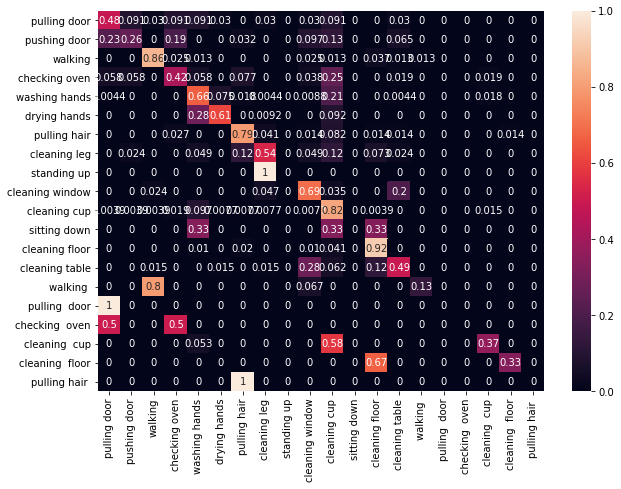

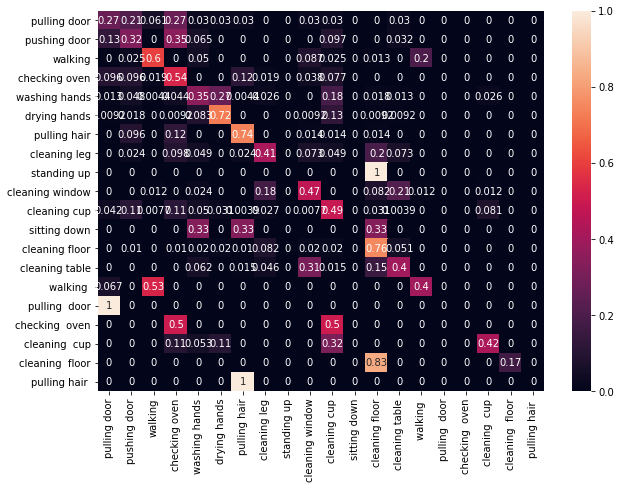

In [40]:
print("Two handed classification")
classify_all(X, labels, label_ids)